In [1]:
import math
import os

from hermite_functions import hermite_functions
from ripser import ripser
from tqdm import tqdm

import matplotlib.pyplot as plt
import gtda.time_series
import numpy as np
import scipy.stats
import cripser
import persim
import wandb
import mne

import tda_utils
import dataset
import utils

import plotly
import plotly.graph_objs as go

from matplotlib import ticker
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Instructions for Accuracy Table/p-value Image

Replace the Weights and Biases run ids in the "runs" dictionary with the weights and biases run ids from your runs for the corresponding feature sets.

In [3]:
runs = {
    "Random Prediction":  "8tj978ao",
    "Baseline":  "5msa185r",
    "HEPC": "rd9f6wqk",
    "HEPC (30 Coefficients)": "11om1h0n",
    "AP-FAPC": "0093mixn",
    "AP-FAPC (30 Coefficients)" : "dz59tce0",
    "SP-FAPC": "dr2382o1",
    "SP-FAPC (30 Coefficients)" : "kyyy2ar0",
    "AP-FAPC + HEPC": "oi96gsme",
    "SP-FAPC + HEPC": "1ipznfzh",
    "Baseline + HEPC": "2hz55li9",
    "Baseline + AP-FAPC": "v1bo90yx",
    "Baseline + SP-FAPC": "4azmy0cu",
    "Baseline + AP-FAPC + HEPC": "w25y990j",
    "Baseline + SP-FAPC + HEPC": "7l5utc66",
    # "Random Prediction":  "yzc3pt9o",
    # "Baseline":  "vm8rhc7i",
    # "HEPC": "04rgwl67",
    # "AP-FAPC": "jh36k3qy",
    # "SP-FAPC": "9wc1fq7q",
    # "AP-FAPC + HEPC": "08ewqjlu",
    # "SP-FAPC + HEPC": "h14hirh4",
    # "Baseline + HEPC": "f0ck7bnl",
    # "Baseline + AP-FAPC": "5c3jhkq5",
    # "Baseline + SP-FAPC": "e1zcs3i5",
    # "Baseline + AP-FAPC + HEPC": "btnbc4c3",
    # "Baseline + SP-FAPC + HEPC": "q3gvisx3",
}
api = wandb.Api()

In [37]:
# Accuracy Table for XGBoost Model
data = {}
for run_name, run_id in runs.items():
    run_data = api.run(f"shashankmanjunath/tda_airflow_sleep_staging/{run_id}")
    run_history = run_data.history()
    data[run_name] = run_history

    train_ba = np.mean(run_history["train_ba"].tolist())
    test_ba = np.mean(run_history["test_ba"].tolist())
    cohen_kappa = np.mean(run_history["cohen_kappa"].tolist())

    test_cmat_arr = np.stack(run_history["test_cmat"].tolist())
    class_acc = np.stack([np.diag(x)/x.sum(1) for x in test_cmat_arr])
    class_acc = class_acc.mean(0)

    print(f"{run_name} & {train_ba:.3f} & {test_ba:.3f} & {cohen_kappa:.3f} & {class_acc[0]:.3f} & {class_acc[1]:.3f} & {class_acc[2]:.3f}" + r" \\")
    print(r"\hline")

Random Prediction & 0.376 & 0.333 & -0.000 & 0.341 & 0.305 & 0.353 \\
\hline
Baseline & 0.650 & 0.627 & 0.335 & 0.598 & 0.683 & 0.599 \\
\hline
HEPC & 0.636 & 0.620 & 0.286 & 0.656 & 0.610 & 0.593 \\
\hline
HEPC (30 Coefficients) & 0.645 & 0.628 & 0.292 & 0.670 & 0.610 & 0.603 \\
\hline
AP-FAPC & 0.629 & 0.616 & 0.256 & 0.736 & 0.547 & 0.564 \\
\hline
AP-FAPC (30 Coefficients) & 0.630 & 0.617 & 0.257 & 0.738 & 0.547 & 0.566 \\
\hline
SP-FAPC & 0.650 & 0.632 & 0.299 & 0.664 & 0.611 & 0.622 \\
\hline
SP-FAPC (30 Coefficients) & 0.651 & 0.633 & 0.300 & 0.663 & 0.613 & 0.622 \\
\hline
AP-FAPC + HEPC & 0.670 & 0.654 & 0.323 & 0.710 & 0.633 & 0.618 \\
\hline
SP-FAPC + HEPC & 0.662 & 0.643 & 0.305 & 0.679 & 0.611 & 0.640 \\
\hline
Baseline + HEPC & 0.681 & 0.660 & 0.350 & 0.676 & 0.670 & 0.634 \\
\hline
Baseline + AP-FAPC & 0.679 & 0.661 & 0.340 & 0.722 & 0.654 & 0.608 \\
\hline
Baseline + SP-FAPC & 0.681 & 0.661 & 0.347 & 0.677 & 0.660 & 0.647 \\
\hline
Baseline + AP-FAPC + HEPC & 0.697 & 0.

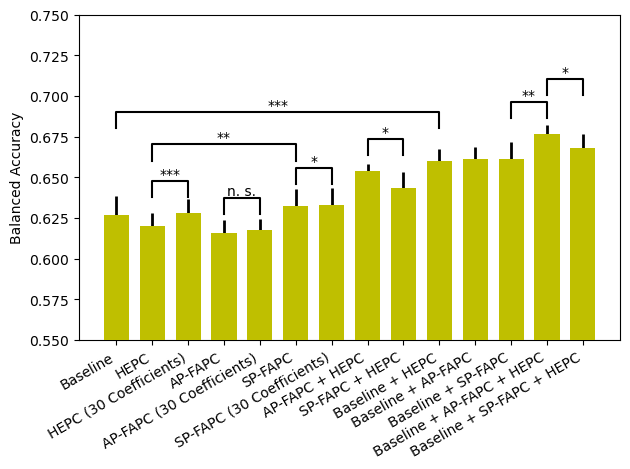

In [38]:
bar_kwargs = {'width': 0.7,'color':'y','linewidth':2,'zorder':5}
err_kwargs = {'zorder':0,'fmt': "none",'linewidth':2,'ecolor':'k'}

ind = []
chart_data = []
errs = []
cohen_kappa = []
for k, v in data.items():
    if k != "Random Prediction":
        ind.append(k)
        chart_data.append(data[k]["test_ba"].tolist())
        cohen_kappa.append(data[k]["cohen_kappa"].tolist())
                 
fig, ax = plt.subplots()
ax.p1 = plt.bar(ind, [np.mean(x) for x in chart_data], **bar_kwargs)
ax.errs = plt.errorbar(ind, [np.mean(x) for x in chart_data], yerr=[np.std(x) for x in chart_data], **err_kwargs)
plt.xticks(rotation=30, ha="right")
plt.ylim([0.55, 0.75])

def barplot_annotate_brackets(num1, num2, data, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    center = np.arange(len(data))
    height = [np.mean(x) for x in data]


    if np.mean(data[num1]) < np.mean(data[num2]):
        alternative = "less"
    else:
        alternative = "greater"
    res = scipy.stats.ttest_rel(data[num1], data[num2], alternative=alternative)
    pvalue = res.pvalue

    # print(num1, num2, pvalue)
    # * is p < 0.05
    # ** is p < 0.005
    # *** is p < 0.0005
    # etc.
    text = ''
    p = .05
    while pvalue < p:
        text += '*'
        p /= 10.
        if maxasterix and len(text) == maxasterix:
            break
    if len(text) == 0:
        text = 'n. s.'

    # text = f"{pvalue:.5f}"

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
    plt.text(*mid, text, **kwargs)

barplot_annotate_brackets(1, 2, chart_data, maxasterix=4, dh=0.05)
barplot_annotate_brackets(3, 4, chart_data, maxasterix=4)
barplot_annotate_brackets(5, 6, chart_data, maxasterix=4, dh=0.065)
barplot_annotate_brackets(1, 5, chart_data, maxasterix=4, dh=0.14)
barplot_annotate_brackets(7, 8, chart_data, maxasterix=4)
barplot_annotate_brackets(0, 9, chart_data, maxasterix=4, dh=0.1)
barplot_annotate_brackets(11, 12, chart_data, maxasterix=4)
barplot_annotate_brackets(12, 13, chart_data, maxasterix=4, dh=0.12)
# barplot_annotate_brackets(6, 8, chart_data, maxasterix=4, dh=0.12)
# barplot_annotate_brackets(9, 10, chart_data, maxasterix=4)
# barplot_annotate_brackets(8, 9, chart_data, maxasterix=4)

plt.ylabel("Balanced Accuracy")
plt.tight_layout()
plt.savefig("results_significance.png", dpi=300)
plt.show()

## PC Approximation using HEPC/AP-FAPC/SP-FAPC Image

Ensure that the runs have been loaded from weights and biases using the previous cells.

In [33]:
# Image of PC approximation
idx = 0
data_dir = "/work/thesathlab/nchsdb/"

pt_ids = []
for pt_file in os.listdir(os.path.join(data_dir, "sleep_data")):
    if pt_file.endswith(".edf"):
        pt_ids.append(pt_file.replace(".edf", ""))

pt_id = pt_ids[idx]

print(pt_id)
save_dir = "/work/thesathlab/manjunath.sh/tmp"
loader = dataset.AirflowSignalProcessor(pt_id=pt_id, data_dir="/work/thesathlab/nchsdb/", save_dir=save_dir)

raw_edf = mne.io.read_raw_edf(loader.edf_fname, verbose=False)
sfreq = raw_edf.info["sfreq"]

target_intervals = loader.find_target_intervals()
airflow_cache = loader.load_epoch_cache(raw_edf, target_intervals)

10000_17728


Loading 10000_17728...: 100%|██████████| 900/900 [00:39<00:00, 23.03it/s]


In [34]:
data = []
dgms_dict = {
    "irr_sublevel": [],
    "airflow_sublevel": [],
    "airflow_rips": [],
}

target_count = 0
count = 0

fapc_support = {
    "rips_airflow_h0": [0, 0.0002],
    "rips_airflow_h1": [0, 0.0005],
    "sublevel_airflow_h0": [-0.0015, 0.0015],
    "sublevel_irr_h0": [10, 50],
}
hepc_scale = {
    "rips_airflow_h0": 90442.544,
    "rips_airflow_h1": 55034.829,
    "sublevel_airflow_h0": 15909.436,
    "sublevel_irr_h0": 0.164,
}

for idx in tqdm(range(len(airflow_cache)), desc=f"Processing {loader.pt_id}..."):
    if count < target_count:
        count += 1
        continue
    data_arr = airflow_cache.get_epoch_sequence(idx, n_epochs=6)
    sqi = utils.calculate_sqi(data_arr, sfreq)

    # Calculate IRR signal
    irr_signal = loader.calc_irr(data_arr.squeeze(), sampling_freq=sfreq)

    # Sublevel set filtration of IRR signal
    sublevel_dgms_irr = loader.sublevel_set_filtration(irr_signal)

    # Airflow rips filtration
    rips_dgms_airflow = loader.rips_filtration(data_arr, sfreq)

    # Airflow sublevel filtration
    sublevel_dgms_airflow = loader.sublevel_set_filtration(data_arr)
    
    sublevel_irr_0_x_scale, sublevel_irr_0_pc_scale = loader.calculate_persistence_curve(sublevel_dgms_irr[0])
    sublevel_airflow_0_x_scale, sublevel_airflow_0_pc_scale = loader.calculate_persistence_curve(sublevel_dgms_airflow[0])
    rips_airflow_0_x_scale, rips_airflow_0_pc_scale = loader.calculate_persistence_curve(rips_dgms_airflow[0])
    rips_airflow_1_x_scale, rips_airflow_1_pc_scale = loader.calculate_persistence_curve(rips_dgms_airflow[1])
    
    hepc_irr = loader.hepc(sublevel_dgms_irr[0], scale=hepc_scale["sublevel_irr_h0"])
    hepc_rips_airflow_0 = loader.hepc(rips_dgms_airflow[0], scale=hepc_scale["rips_airflow_h0"])
    hepc_rips_airflow_1 = loader.hepc(rips_dgms_airflow[1], scale=hepc_scale["rips_airflow_h1"])
    hepc_sub_airflow_0 = loader.hepc(sublevel_dgms_airflow[0], scale=hepc_scale["sublevel_airflow_h0"])

    L_sublevel_irr = fapc_support["sublevel_irr_h0"][1] - fapc_support["sublevel_irr_h0"][0]
    sp_fapc_irr = loader.fapc_closed_form(sublevel_dgms_irr[0], L=L_sublevel_irr)
    ap_fapc_irr = loader.fapc_closed_form(sublevel_dgms_irr[0])
    
    L_rips_airflow_h0 = fapc_support["rips_airflow_h0"][1] - fapc_support["rips_airflow_h0"][0]
    sp_fapc_rips_airflow_0 = loader.fapc_closed_form(rips_dgms_airflow[0], L=L_rips_airflow_h0)
    ap_fapc_rips_airflow_0 = loader.fapc_closed_form(rips_dgms_airflow[0])
    
    L_rips_airflow_h1 = fapc_support["rips_airflow_h1"][1] - fapc_support["rips_airflow_h1"][0]
    sp_fapc_rips_airflow_1 = loader.fapc_closed_form(rips_dgms_airflow[1], L=L_rips_airflow_h1)
    ap_fapc_rips_airflow_1 = loader.fapc_closed_form(rips_dgms_airflow[1])
    
    L_sublevel_airflow = fapc_support["sublevel_airflow_h0"][1] - fapc_support["sublevel_airflow_h0"][0]
    sp_fapc_sub_airflow_0 = loader.fapc_closed_form(sublevel_dgms_airflow[0], L=L_sublevel_airflow)
    ap_fapc_sub_airflow_0 = loader.fapc_closed_form(sublevel_dgms_airflow[0])

    # Skipping if we have very few points in filtration
    if np.isnan(sublevel_dgms_irr[0]).sum() > 0:
        continue

    count += 1
    
    if count >= target_count:
        break

Processing 10000_17728...:   0%|          | 0/633 [00:05<?, ?it/s]


/tmp/ipykernel_22503/794199120.py:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_22503/794199120.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_22503/794199120.py:84: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_22503/794199120.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=45, ha="right")
/tmp/ipykernel_2

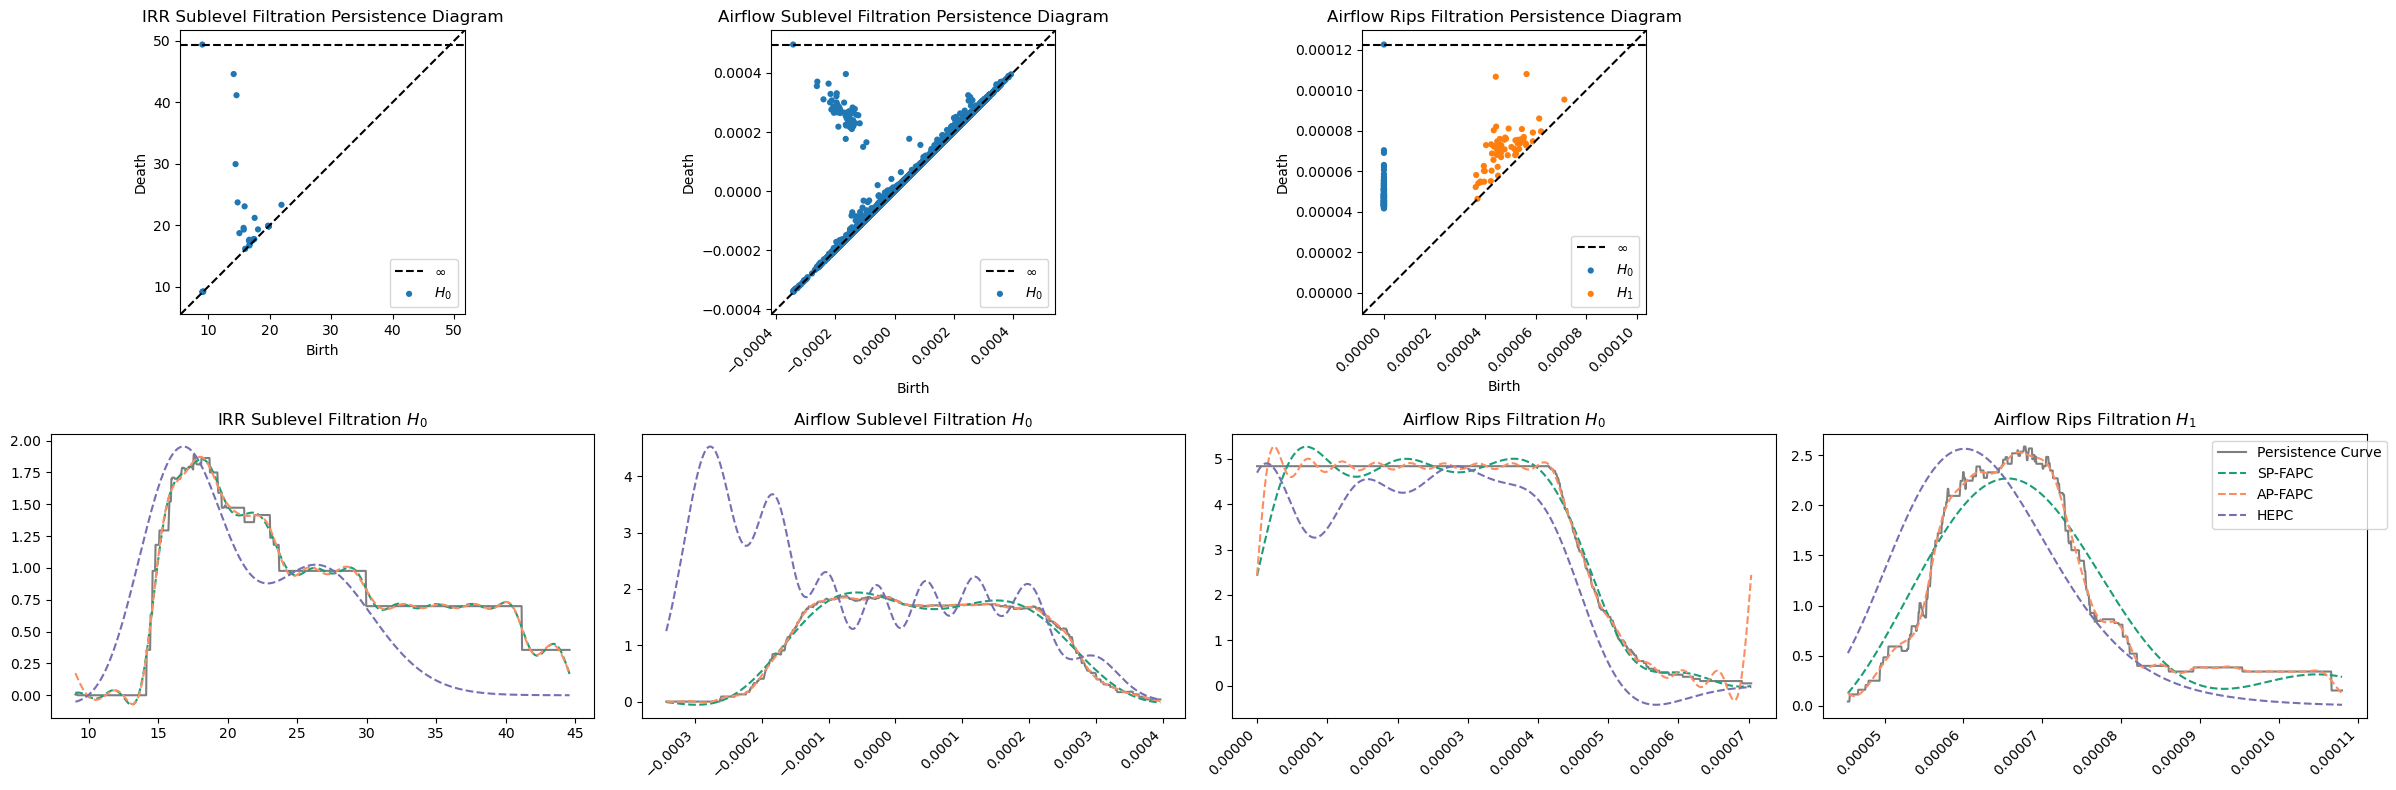

In [41]:
n_approx = 15

def get_hermite_approx(coefs, x):
    y_pred = np.zeros(x.shape[0])
    for n, coef in enumerate(coefs):
        hn = hermite_functions(n, x, all_n=False)
        y_pred += coef * hn
    return y_pred

def get_fapc_approx(coefs, x, L=None):
    if not L:
        L = x[-1] - x[0]
    approx_cf = np.zeros(x.shape)
    for n, beta_n in enumerate(coefs):
        if n == 0:
            approx_cf += np.real(beta_n) / 2
        else:
            approx_cf += np.real(beta_n) * np.cos(2 * np.pi * n * x / L) + np.imag(beta_n) * np.sin(2 * np.pi * n * x / L)
    return approx_cf

def calculate_persistence_curve(dgm):
    dgm_clean = dgm[~np.isinf(dgm).any(1)]
    psi_dgms = tda_utils.psi(dgm_clean)
    x = np.linspace(dgm_clean.min(), dgm_clean.max(), 1000)
    y = np.zeros(x.shape)

    for idx, (b, d) in enumerate(dgm_clean):
        arr_idx = (x >= b) & (x <= d)
        y[arr_idx] += psi_dgms[idx]
    return x, y

# Calculating scaled fit
sublevel_irr_0_x_scale, sublevel_irr_0_pc_scale = calculate_persistence_curve(sublevel_dgms_irr[0] * dataset.hepc_scale["sublevel_irr_h0"])
sublevel_airflow_0_x_scale, sublevel_airflow_0_pc_scale = calculate_persistence_curve(sublevel_dgms_airflow[0] * dataset.hepc_scale["sublevel_airflow_h0"])
rips_airflow_0_x_scale, rips_airflow_0_pc_scale = calculate_persistence_curve(rips_dgms_airflow[0] * dataset.hepc_scale["rips_airflow_h0"])
rips_airflow_1_x_scale, rips_airflow_1_pc_scale = calculate_persistence_curve(rips_dgms_airflow[1] * dataset.hepc_scale["rips_airflow_h1"])

# Calculating original x spacing
sublevel_irr_0_x, sublevel_irr_0_pc = calculate_persistence_curve(sublevel_dgms_irr[0])
sublevel_airflow_0_x, sublevel_airflow_0_pc = calculate_persistence_curve(sublevel_dgms_airflow[0])
rips_airflow_0_x, rips_airflow_0_pc = calculate_persistence_curve(rips_dgms_airflow[0])
rips_airflow_1_x, rips_airflow_1_pc = calculate_persistence_curve(rips_dgms_airflow[1])

# fft_irr_approx = np.fft.irfft(fft_irr[:n_approx], n=sublevel_irr_0_pc.shape[0])
sp_fapc_irr_approx = get_fapc_approx(sp_fapc_irr[:n_approx], sublevel_irr_0_x, L=L_sublevel_irr)
ap_fapc_irr_approx = get_fapc_approx(ap_fapc_irr[:n_approx], sublevel_irr_0_x)
h_irr_approx = get_hermite_approx(hepc_irr[:n_approx], sublevel_irr_0_x_scale)

sp_fapc_sub_airflow_0_approx = get_fapc_approx(sp_fapc_sub_airflow_0[:n_approx], sublevel_airflow_0_x, L=L_sublevel_airflow)
ap_fapc_sub_airflow_0_approx = get_fapc_approx(ap_fapc_sub_airflow_0[:n_approx], sublevel_airflow_0_x)
h_sub_airflow_0_approx = get_hermite_approx(hepc_sub_airflow_0[:n_approx], sublevel_airflow_0_x_scale)

sp_fapc_rips_airflow_0_approx = get_fapc_approx(sp_fapc_rips_airflow_0[:n_approx], rips_airflow_0_x, L=L_rips_airflow_h0)
ap_fapc_rips_airflow_0_approx = get_fapc_approx(ap_fapc_rips_airflow_0[:n_approx], rips_airflow_0_x)
h_rips_airflow_0_approx = get_hermite_approx(hepc_rips_airflow_0[:n_approx], rips_airflow_0_x_scale)

sp_fapc_rips_airflow_1_approx = get_fapc_approx(sp_fapc_rips_airflow_1[:n_approx], rips_airflow_1_x, L=L_rips_airflow_h1)
ap_fapc_rips_airflow_1_approx = get_fapc_approx(ap_fapc_rips_airflow_1[:n_approx], rips_airflow_1_x)
h_rips_airflow_1_approx = get_hermite_approx(hepc_rips_airflow_1[:n_approx], rips_airflow_1_x_scale)

plt.close("all")
                
fig, ax = plt.subplots(2, 4, figsize=(24, 8))
persim.plot_diagrams(sublevel_dgms_irr, ax=ax[0, 0])
ax[0, 0].set_title("IRR Sublevel Filtration Persistence Diagram")
ax[1, 0].plot(sublevel_irr_0_x, sublevel_irr_0_pc, label="Persistence Curve", color="k", linestyle="-", alpha=0.5)
ax[1, 0].plot(sublevel_irr_0_x, sp_fapc_irr_approx, label="SP-FAPC", linestyle="--", color="#1b9e77")
ax[1, 0].plot(sublevel_irr_0_x, ap_fapc_irr_approx, label="AP-FAPC", linestyle="--", color="#fc8d62")
ax[1, 0].plot(sublevel_irr_0_x, h_irr_approx, label="HEPC", linestyle="--", color="#7570b3")
ax[1, 0].set_title("IRR Sublevel Filtration $H_0$")

persim.plot_diagrams(sublevel_dgms_airflow, ax=ax[0, 1])
ax[0, 1].set_title("Airflow Sublevel Filtration Persistence Diagram")
ax[0, 1].set_xticklabels(ax[0, 1].get_xticklabels(), rotation=45, ha="right")
ax[1, 1].plot(sublevel_airflow_0_x, sublevel_airflow_0_pc, label="Persistence Curve", color="k", alpha=0.5)
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=45, ha="right")
ax[1, 1].plot(sublevel_airflow_0_x, sp_fapc_sub_airflow_0_approx, label="SP-FAPC", linestyle="--", color="#1b9e77")
ax[1, 1].plot(sublevel_airflow_0_x, ap_fapc_sub_airflow_0_approx, label="AP-FAPC", linestyle="--", color="#fc8d62")
ax[1, 1].plot(sublevel_airflow_0_x, h_sub_airflow_0_approx, label="HEPC", linestyle="--", color="#7570b3")
ax[1, 1].set_title("Airflow Sublevel Filtration $H_0$")

persim.plot_diagrams(rips_dgms_airflow, ax=ax[0, 2])
ax[0, 2].set_title("Airflow Rips Filtration Persistence Diagram")
ax[0, 2].set_xticklabels(ax[0, 2].get_xticklabels(), rotation=45, ha="right")
ax[1, 2].plot(rips_airflow_0_x, rips_airflow_0_pc, label="Persistence Curve", color="k", alpha=0.5)
ax[1, 2].set_xticklabels(ax[1, 2].get_xticklabels(), rotation=45, ha="right")
ax[1, 2].xaxis.set_major_formatter(ticker.FuncFormatter("{:.5f}".format))
ax[1, 2].plot(rips_airflow_0_x, sp_fapc_rips_airflow_0_approx, label="SP-FAPC", linestyle="--", color="#1b9e77")
ax[1, 2].plot(rips_airflow_0_x, ap_fapc_rips_airflow_0_approx, label="AP-FAPC", linestyle="--", color="#fc8d62")
ax[1, 2].plot(rips_airflow_0_x, h_rips_airflow_0_approx, label="HEPC", linestyle="--", color="#7570b3")
ax[1, 2].set_title("Airflow Rips Filtration $H_0$")

ax[0, 3].axis("off")
ax[1, 3].plot(rips_airflow_1_x, rips_airflow_1_pc, label="Persistence Curve", color="k", alpha=0.5)
ax[1, 3].set_xticklabels(ax[1, 3].get_xticklabels(), rotation=45, ha="right")
ax[1, 3].plot(rips_airflow_1_x, sp_fapc_rips_airflow_1_approx, label="SP-FAPC", linestyle="--", color="#1b9e77")
ax[1, 3].plot(rips_airflow_1_x, ap_fapc_rips_airflow_1_approx, label="AP-FAPC", linestyle="--", color="#fc8d62")
ax[1, 3].plot(rips_airflow_1_x, h_rips_airflow_1_approx, label="HEPC", linestyle="--", color="#7570b3")
ax[1, 3].set_title("Airflow Rips Filtration $H_1$")


ax[1, 3].legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig("pc_approx.png", dpi=300)
plt.show()

# Extras

Some extra images not included in the paper can be generated from the following cells.

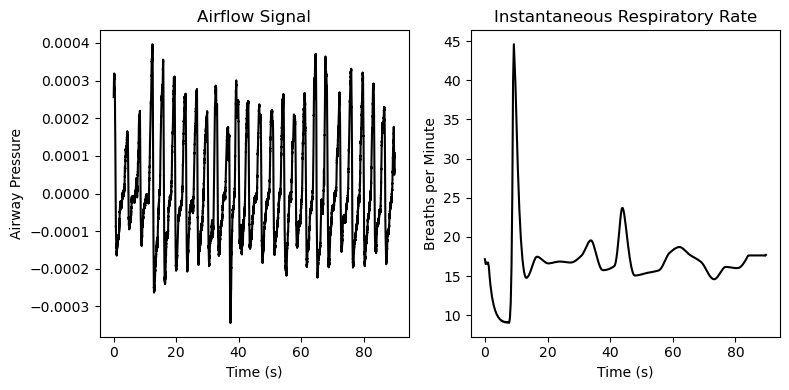

In [9]:
# Image of Instantaneous Respiratory Rate from Airflow signal
data_select = data_arr[0, :int(sfreq*90)].squeeze()
irr_signal = loader.calc_irr(data_select, sampling_freq=sfreq)
t = np.arange(data_select.shape[-1]) / sfreq
t_irr = np.arange(irr_signal.shape[-1]) / loader.target_resamp_rate

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(t, data_select, color="k")
axs[0].set_title("Airflow Signal")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Airway Pressure")
axs[1].plot(t_irr, irr_signal, color="k")
axs[1].set_title("Instantaneous Respiratory Rate")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Breaths per Minute")

plt.tight_layout()
plt.savefig("irr.png", dpi=300)
plt.show()

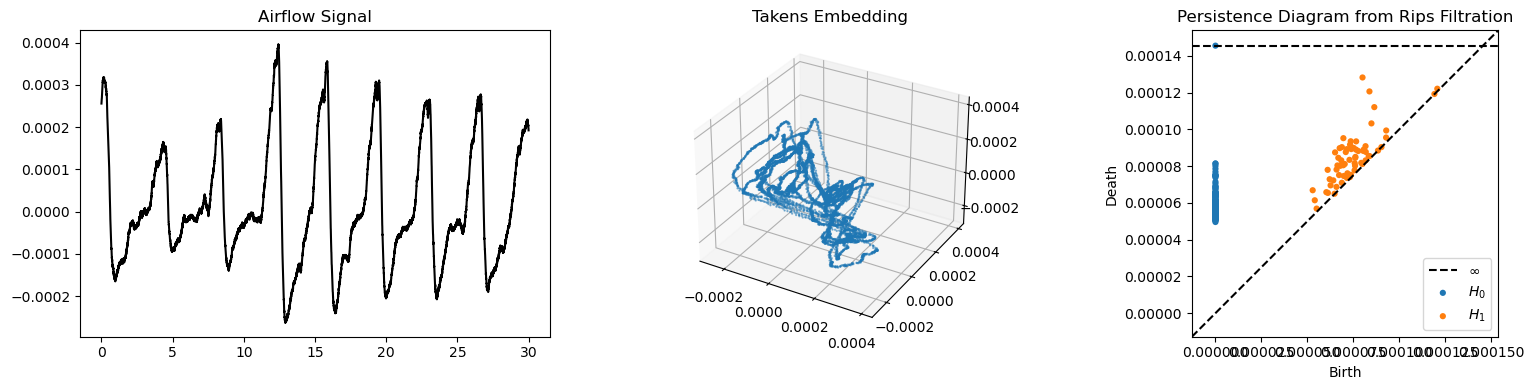

In [10]:
# Signal-Takens Embedding-PD
data_select = data_arr[0, :int(sfreq*30)].squeeze()
t = np.arange(data_select.shape[-1]) / sfreq
n_seconds = 1
tau = int(sfreq * n_seconds)

embedder = gtda.time_series.TakensEmbedding(time_delay=tau, dimension=3)
embedded_signal = embedder.fit_transform(data_select[None, :]).squeeze()
dgms = ripser(embedded_signal, n_perm=128)["dgms"]

fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133)

ax1.plot(t, data_select, color="k")
ax1.set_title("Airflow Signal")

ax2.scatter(embedded_signal[:, 0], embedded_signal[:, 1], embedded_signal[:, 2], alpha=0.5, s=0.5)
ax2.set_title("Takens Embedding")

persim.plot_diagrams(dgms, ax=ax3)
ax3.set_title("Persistence Diagram from Rips Filtration")

plt.tight_layout()
plt.savefig("rips_pipeline.png", dpi=300)
plt.show()

# Sublevel Filtration Example Image

The following cell is used to generate part of the sublevel filtration example image included in the paper.

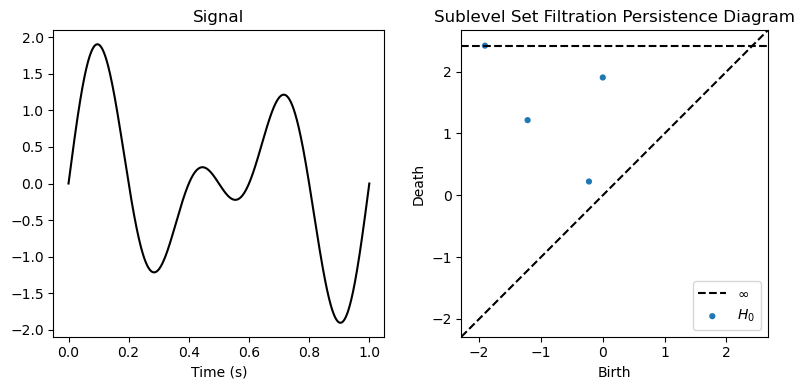

In [11]:
# Signal-Sublevel Filtration-PD

f1 = 3
f2 = 2

t = np.linspace(0, 1, 1000)
y = np.sin(2 * np.pi * t * f1) + np.sin(2 * np.pi * t * f2)

pd = cripser.computePH(y, maxdim=0)
dgm0 = pd[:, 1:3]
dgm0[-1, -1] = np.inf

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].plot(t, y, color="k")
axs[0].set_title("Signal")
axs[0].set_xlabel("Time (s)")
axs[1].set_ylabel("Amplitude")

persim.plot_diagrams(dgm0, ax=axs[1])
axs[1].set_title("Sublevel Set Filtration Persistence Diagram")

plt.tight_layout()
plt.savefig("sublevel_set_filtration.png", dpi=300)
plt.show()